In [1]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime
import math
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)
 
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
plt.style.use("fivethirtyeight")

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200


In [2]:
# MetaTrader5 login credentials
login = 
password = 
server = 

mt5.login(login,password,server)

True

In [3]:
# Fetch historical gold prices
date_from=datetime.datetime(2023, 1, 1)
date_to=datetime.datetime.today()
ticker_symbol="XAUUSD"
rates=mt5.copy_rates_range(ticker_symbol, mt5.TIMEFRAME_H1, date_from, date_to)

In [4]:
# Create a new datetime column from the time column in unix_timestamps
hist_df=pd.DataFrame(rates)
hist_df['Time']=pd.to_datetime(hist_df['time'], unit="s")
hist_df=hist_df.drop(columns=['time', 'real_volume'])

In [5]:
# Reindex the column
new_column_order = ['Time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread']
hist_df = hist_df.reindex(columns=new_column_order)
hist_df.head()

,Time,open,high,low,close,tick_volume,spread
0,2023-01-03 01:00:00,1826.72,1830.68,1823.56,1829.32,1719,8
1,2023-01-03 02:00:00,1829.32,1832.13,1828.70,1830.59,2137,8
2,2023-01-03 03:00:00,1830.59,1832.38,1826.71,1828.51,4589,8
3,2023-01-03 04:00:00,1828.47,1839.80,1828.26,1838.35,4265,8
4,2023-01-03 05:00:00,1838.35,1843.06,1838.35,1841.09,3032,8


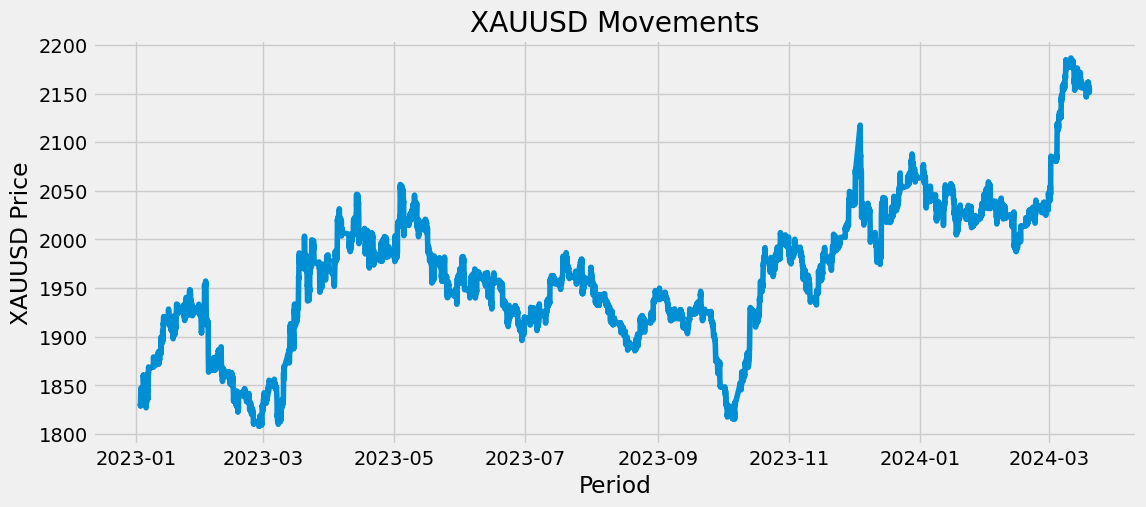

In [6]:
# Plot the Gold price movements
plt.figure(figsize=(12, 5))
plt.plot(hist_df['Time'], hist_df['close'], label=f'Closing {ticker_symbol} Movement')
plt.xlabel("Period")
plt.ylabel(f"{ticker_symbol} Price")
plt.title(f"{ticker_symbol} Movements");

In [7]:
# Filter the data for closing day values to be used for training and test of the model
data = hist_df.filter(['close'])
data.index=hist_df['Time']
train_len = math.ceil(len(data)*0.8)

In [59]:
#Scale the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
#Training Data
train_data = scaled_data[:train_len]
x_train = []
y_train = []

for i in range(120, len(train_data)):
  x_train.append(train_data[i-120:i, 0])
  y_train.append(train_data[i, 0])
  if i<=120:
    print(x_train)
    print(y_train)


[array([0.05652507, 0.05987803, 0.05438657, 0.08036539, 0.08759933,
       0.08559284, 0.08575125, 0.08984344, 0.10433772, 0.07442511,
       0.08165905, 0.07004251, 0.06666315, 0.07046493, 0.08176466,
       0.09779022, 0.06668955, 0.06959368, 0.0826095 , 0.08165905,
       0.08221348, 0.07975816, 0.08332233, 0.07524355, 0.08107823,
       0.09602133, 0.09984951, 0.09940069, 0.10212002, 0.10143359,
       0.10542018, 0.13293027, 0.13741849, 0.13894976, 0.13446155,
       0.1378145 , 0.1208649 , 0.13760329, 0.12963012, 0.13158381,
       0.13372231, 0.11244291, 0.11244291, 0.11764395, 0.1250627 ,
       0.12329382, 0.12363704, 0.12464028, 0.13430314, 0.1291813 ,
       0.11972965, 0.1165615 , 0.11780236, 0.11297093, 0.10943317,
       0.1016712 , 0.10721546, 0.10861473, 0.10122238, 0.09881986,
       0.07086094, 0.0699633 , 0.04995116, 0.06011564, 0.06861684,
       0.07379148, 0.06967289, 0.06624073, 0.06589751, 0.06584471,
       0.06977849, 0.07276183, 0.08002218, 0.08279431, 0.0794

In [10]:
#convert the x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape training data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape, y_train.shape

((5618, 120, 1), (5618,))

In [11]:
#Build Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

5618/5618 ━━━━━━━━━━━━━━━━━━━━ 347s 59ms/step - loss: 0.0018


In [14]:
#create the testing data
test_data = scaled_data[train_len-120: , :]
#create x_test and y_test
x_test = []
y_test = data.values[train_len:, : ]

for i in range(120, len(test_data)):
  x_test.append(test_data[i-120:i, 0])

In [15]:
#Convert test data to numpy arrays and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(1434, 120, 1)

In [16]:
#model predictions
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [17]:
#RSME
rsme = np.sqrt(np.mean(predict-y_test)**2)
rsme

13.472264518365364

In [31]:
#add a datetime index to future_x
start_dt=hist_df.loc[hist_df.index[-1],'Time']
end_dt=hist_df.loc[hist_df.index[-1],'Time']+datetime.timedelta(hours=119)
hourly_range=pd.date_range(start=start_dt, end=end_dt, freq='H')
hourly_range.shape

(120,)

In [57]:
y=model.predict(data.values[-120:].reshape(1, 120, 1))
scaler.inverse_transform(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[3491.9023]], dtype=float32)

C:\Users\Vincent Gesanda\AppData\Local\Temp\ipykernel_8780\434174546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predict


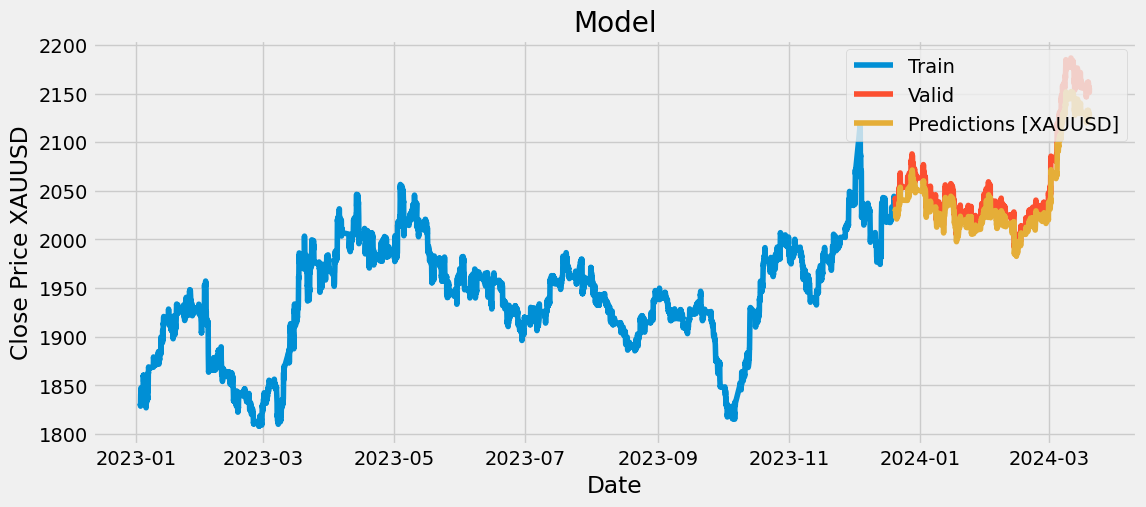

In [58]:
#plot the data
train = data[:train_len]
valid = data[train_len:]
valid.loc[:,'Predictions'] = predict

#visualize the data
plt.figure(figsize=(12, 5))
plt.title('Model')
plt.ylabel(f"Close Price {ticker_symbol}")
plt.xlabel("Date")
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Valid', f'Predictions [{ticker_symbol}]'], loc='upper right');

In [ ]:
# Future prices prediction and reindex them with datetime data
future_x = data.values[-120:].reshape(1, 120, 1)  # Take the last 120 values as input for prediction

# Predict future prices
predicted_values = []
for _ in range(120):
    prediction = model.predict(future_x)
    prediction=scaler.inverse_transform(prediction)
    predicted_values.append(prediction)
    future_x = np.append(future_x[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert list to numpy array
predicted_values = np.array(predicted_values).squeeze()  